In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


In [ ]:
df = pd.read_csv("/flipkart_500k_messy_raw_data.csv")
df.head()


/tmp/ipython-input-121117639.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/flipkart_500k_messy_raw_data.csv")


,order_id,order_date,customer_id,customer_type,city,state,region,product_category,product_sub_category,payment_mode,order_value,discount_percent,cost_price,profit,delivery_days,delivery_delay_flag,order_status
0,1.0,03-02-2024 00:00,784673.0,New,Hyderabad,KA,West,Home,Furniture,Debit Card,5864.70,10.0,4358.676944,919.55,8.0,True,Delivered
1,2.0,27-09-2024 00:00,647875.0,New,Hyderabad,KA,West,Electronics,Daily Needs,Credit Card,5339.47,10.0,3957.196466,848.33,8.0,True,Delivered
2,3.0,11-11-2024 00:00,277337.0,Returning,Chennai,MH,West,Home,Clothing,UPI,1699.66,40.0,1179.830016,-160.03,5.0,False,Delivered
3,4.0,05-02-2023 00:00,791368.0,Returning,Mumbai,MH,West,NaN,NaN,NaN,3097.78,30.0,NaN,NaN,6.0,True,Delivered
4,5.0,28-03-2024 00:00,339305.0,Returning,Kolkata,TN,South,NaN,Mobile,COD,1087.70,0.0,563.360083,524.34,2.0,False,Delivered


In [ ]:
df.shape


(512000, 17)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512000 entries, 0 to 511999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              500000 non-null  float64
 1   order_date            500000 non-null  object 
 2   customer_id           500000 non-null  float64
 3   customer_type         465103 non-null  object 
 4   city                  449910 non-null  object 
 5   state                 449822 non-null  object 
 6   region                449969 non-null  object 
 7   product_category      416909 non-null  object 
 8   product_sub_category  416684 non-null  object 
 9   payment_mode          449998 non-null  object 
 10  order_value           500000 non-null  float64
 11  discount_percent      464765 non-null  float64
 12  cost_price            460038 non-null  float64
 13  profit                460038 non-null  float64
 14  delivery_days         500000 non-null  float64
 15  

In [ ]:
df.isnull().sum().sort_values(ascending=False)


,0
product_sub_category,95316
product_category,95091
state,62178
city,62090
region,62031
payment_mode,62002
cost_price,51962
profit,51962
discount_percent,47235
customer_type,46897


In [ ]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipython-input-2608377066.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-2608377066.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)


In [ ]:
date_cols = [col for col in df.columns if 'date' in col.lower()]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
if 'price' in df.columns:
    df = df[df['price'] > 0]

if 'quantity' in df.columns:
    df = df[df['quantity'] > 0]


In [ ]:
if {'price','quantity'}.issubset(df.columns):
    df['order_value'] = df['price'] * df['quantity']


In [ ]:
customer_df = df.groupby('customer_id').agg(
    total_orders=('order_id','count'),
    total_spent=('order_value','sum'),
    avg_order_value=('order_value','mean'),
    last_purchase=('order_date','max')
).reset_index()


In [ ]:
customer_df['recency_days'] = (df['order_date'].max() - customer_df['last_purchase']).dt.days


In [ ]:
df.groupby('product_category')['order_value'].sum().sort_values(ascending=False).head(10)

,order_value
product_category,
Grocery,5.809029e+08
Appliances,2.910272e+08
Fashion,2.909176e+08
Home,2.903671e+08
Electronics,2.902771e+08


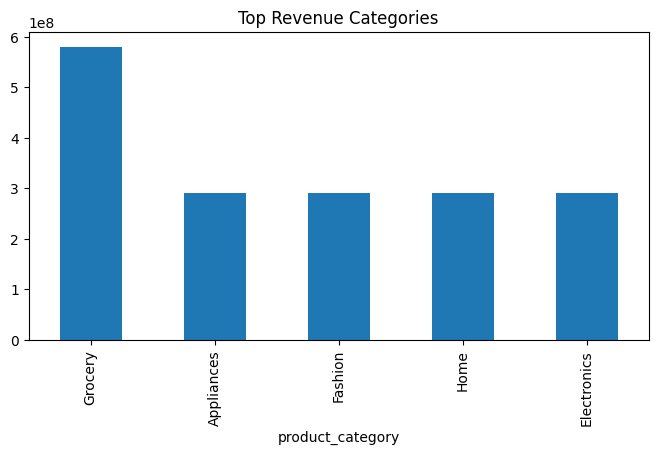

In [ ]:
plt.figure(figsize=(8,4))
df.groupby('product_category')['order_value'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top Revenue Categories")
plt.show()

In [ ]:
customer_df.sort_values('total_spent', ascending=False).head(10)


,customer_id,total_orders,total_spent,avg_order_value,last_purchase,recency_days
24103,156139.0,6,34936.49,5822.748333,2023-08-08,492.0
186986,538354.0,7,34393.24,4913.320000,2024-12-07,5.0
277990,751870.0,3,33890.88,11296.960000,2024-06-01,194.0
84811,298175.0,5,33069.60,6613.920000,2024-09-06,97.0
250949,688729.0,6,32788.45,5464.741667,2023-07-05,526.0
368652,965175.0,2,31282.07,15641.035000,2023-11-05,403.0
167792,492844.0,2,31257.30,15628.650000,2023-09-08,461.0
365230,957058.0,2,31022.94,15511.470000,NaT,NaN
366466,959980.0,6,30566.58,5094.430000,NaT,NaN
228159,635321.0,4,30504.12,7626.030000,2024-12-03,9.0


In [ ]:
customer_df['revenue_risk'] = np.where(
    (customer_df['recency_days'] > 60) & (customer_df['total_orders'] < 3),
    'High Risk',
    'Low Risk'
)


In [ ]:
customer_df['revenue_risk'].value_counts()


,count
revenue_risk,
Low Risk,234099
High Risk,149315


In [ ]:
#Product Sales Success Prediction using E-Commerce Data
product_df = df.groupby('product_category').agg(
    total_revenue=('order_value','sum'),
    total_profit=('profit','sum'),
    avg_discount_percent=('discount_percent','mean'),
    total_orders=('order_id','count')
).reset_index()

In [ ]:
product_df['high_sales'] = np.where(
    product_df['total_revenue'] > product_df['total_revenue'].median(),
    1,
    0
)



In [ ]:
X = product_df[['total_revenue','total_profit','avg_discount_percent','total_orders']]
y = product_df['high_sales']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.0


In [ ]:
feature_importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

feature_importance


,0
total_revenue,0.000060
total_profit,0.000042
avg_discount_percent,-0.008901
total_orders,-0.239455
